In [ ]:
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from keras.models import load_model
loaded_model = load_model('herb_classification_model.h5')

In [ ]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 64)      

In [ ]:
import numpy as np
import cv2
import os
import skimage.io
from skimage import measure
import skimage
from matplotlib import image as mpimg
from sklearn.cluster import KMeans

In [ ]:
# !pip install keras_ocr
import keras_ocr


In [ ]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

In [ ]:

pipeline = keras_ocr.pipeline.Pipeline()

def remove_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
#create images without words
from google.colab import drive
drive.mount('/content/gdrive')
import glob
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
pipeline = keras_ocr.pipeline.Pipeline()
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        path = os.path.join(directory,photo_file,"input.jpg")
        img = remove_text(path,pipeline)  #returned image is inverted
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert to RGB
        out_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        cv2.imwrite(out_path,img_rgb)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 67s 67s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 2s 2s/step


In [ ]:
def get_properties(img_path, blur=None):
    # Load image
    img = skimage.io.imread(img_path)
    print(type(img))
    if blur != None:
        if blur == "gaussian":
            img = skimage.filters.gaussian(img)
        elif blur == 'median':
            img = skimage.filters.median(img)
        elif blur == 'bilateral':
            img = skimage.filters.rank.mean_bilateral(img)
        elif blur == 'total_variation':
            img = skimage.restoration.denoise_tv_chambolle(img)
    # Convert to binary image
    bwimg = img > skimage.filters.threshold_otsu(img)
    # Label connected components in the binary image
    labeled_img = measure.label(bwimg,)
    # Compute region properties for each object
    stats = measure.regionprops(labeled_img)
    # future feature try to filter to remove dots that aren't "green enough"
    # results = []
    # for obj in stats:
    #     y, x, z = obj.centroid
    #     results.append(img[round(y),round(x),:])
    # print(np.array(results).mean(axis = 0))
    return stats

def annotate_center(img_path, stats, out_path):
    fig, ax = plt.subplots()
    img = mpimg.imread(img_path)
    ax.imshow(img)
    # green_color = [0, 1, 0]
    for obj in stats:
        y, x, z = obj.centroid
        # Retrieve pixel value at (x, y) coordinate
        # pixel_value = img[round(y), round(x), :]
        # # Compute Euclidean distance between pixel color and green color
        # dist = np.linalg.norm(pixel_value - green_color)
        # # Define distance threshold
        # threshold = 0.85  # Adjust this value based on how close you want the pixel to be to green
        # if dist <= threshold: # filter to see if plant part or not
        ax.plot(x, y, 'ro')
    ax.set_axis_off()
    dpi = img.shape[0] / fig.get_size_inches()[0] 
    plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)

In [ ]:
def showGreen(img_path):
    #read image
    src = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    print(src.shape)

    # extract green channel
    green_channel = src[:,:,1]

    # create empty image with same shape as that of src image
    green_img = np.zeros(src.shape)

    #assign the green channel of src to empty image
    green_img[:,:,1] = green_channel
    fig, ax = plt.subplots()
    ax.imshow(green_img)
    #save image
    #cv2.imwrite('D:/cv2-green-channel.png',green_img)

In [ ]:
#debugging filter
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img7"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        # stats = get_properties(img_path,'gaussian')
        showGreen(img_path)

In [ ]:
#debugging filter
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img17"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        stats = get_properties(img_path,'gaussian')

<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1142, 1170, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


<class 'numpy.ndarray'>


<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1134, 1058, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


<class 'numpy.ndarray'>


<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (805, 792, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


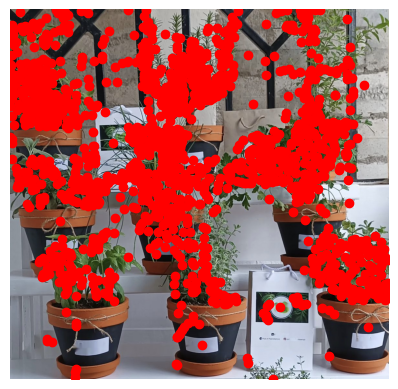

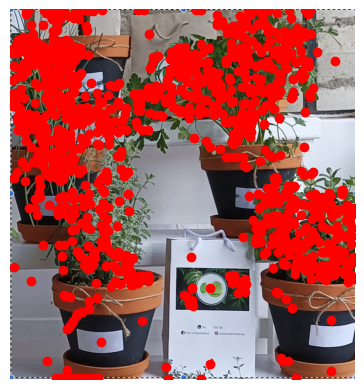

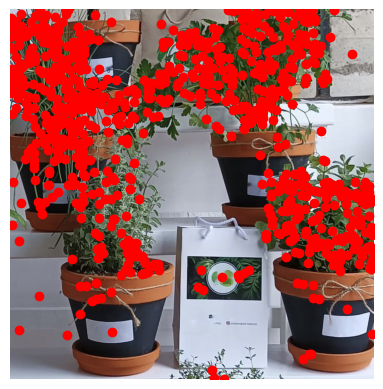

In [ ]:
#annotate center
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        stats = get_properties(img_path,'gaussian')
        out_path = os.path.join(directory,photo_file,"annotateCenterOutput.png")
        annotate_center(img_path,stats,out_path)

In [ ]:
def get_center(stats,n_clusters = 5):
    raw_data =  [obj.centroid for obj in stats]
    kmeans = KMeans(n_clusters= n_clusters, random_state=0, n_init="auto").fit(raw_data)
    return kmeans.cluster_centers_

def annotate_true_center(img_path, center, out_path):
    fig, ax = plt.subplots()
    img = mpimg.imread(img_path)
    ax.imshow(img)
    for obj in center:
        y = obj[0]
        x = obj[1]
        ax.plot(x, y, 'ro')
    ax.set_axis_off()
    dpi = img.shape[0] / fig.get_size_inches()[0] 
    plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)

In [ ]:
num_clusters = {0:3,1:4,2:5,3:10,4:8,5:7,6:10,7:11,8:8,9:8,10:9,11:3,12:7,13:4,14:8,15:11,16:6,17:4,18:8,19:3,20:9,21:4,22:4}

<class 'numpy.ndarray'>


<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1142, 1170, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1134, 1058, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (805, 792, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


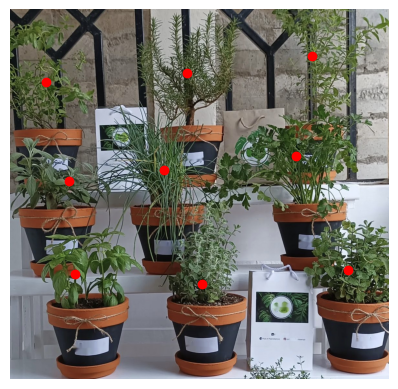

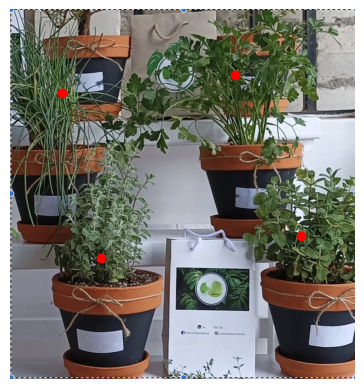

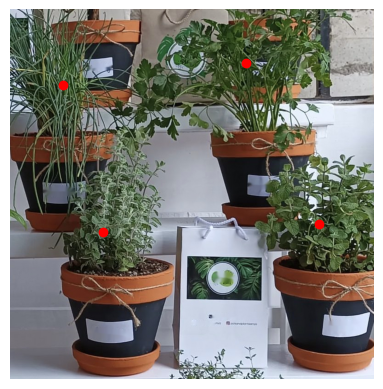

In [ ]:
#annotate center
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        stats = get_properties(img_path,'gaussian')
        out_path = os.path.join(directory,photo_file,"centerOutput.png")
        n = num_clusters[int(photo_file[3:])]
        center = get_center(stats,n_clusters = n)
        annotate_true_center(img_path,center,out_path)

In [ ]:
def extract_image_subset_box(image, x, y, size, out_path):
    """
    Extracts a subset of an input image centered around a given (x, y) coordinate.

    Parameters:
        image (numpy.ndarray): Input image.
        x (int): x-coordinate of center pixel.
        y (int): y-coordinate of center pixel.
        size (int): Size of output image subset.

    Returns:
        numpy.ndarray: Output image subset.
    """

    # Determine bounds of output subset
    x_min = max(0, x - size // 2)
    x_max = min(image.shape[1], x + size // 2)
    y_min = max(0, y - size // 2)
    y_max = min(image.shape[0], y + size // 2)
    img=cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    return img

def extract_image_subset(image, x, y, size, out_path):
    """
    Extracts a subset of an input image centered around a given (x, y) coordinate.

    Parameters:
        image (numpy.ndarray): Input image.
        x (int): x-coordinate of center pixel.
        y (int): y-coordinate of center pixel.
        size (int): Size of output image subset.

    Returns:
        numpy.ndarray: Output image subset.
    """

    # Determine bounds of output subset
    x_min = max(0, x - size // 2)
    x_max = min(image.shape[1], x + size // 2)
    y_min = max(0, y - size // 2)
    y_max = min(image.shape[0], y + size // 2)

    # Extract image subset
    subset = image[y_min:y_max, x_min:x_max]
    fig, ax = plt.subplots()
    
    ax.imshow(subset)
    ax.set_axis_off()
    dpi = image.shape[0] / fig.get_size_inches()[0] 
    plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)

    return subset

    # Extract image subset
    # subset = image[y_min:y_max, x_min:x_max]
    # fig, ax = plt.subplots()
    # ax.imshow(subset)
    # ax.set_axis_off()
    # dpi = image.shape[0] / fig.get_size_inches()[0] 
    #  plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)



def get_subImages_box(img_path, centers, out_folder):

    img = mpimg.imread(img_path)
    
    
    # img = np.vstack([x])


    img_size = img.shape[1] * img.shape[0]
    num_objects = centers.shape[0]
    out_img_size = round(math.sqrt(img_size / (num_objects * 1.5)))
    count = 0
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    for center in centers:
        y = round(center[0])
        x = round(center[1])
        out_img_path = os.path.join(out_folder,f"subset_{count}.png")


        extract_image_subset(mpimg.imread(img_path),x,y,out_img_size,out_img_path )
        img2= load_img(out_img_path, target_size=(224, 224))
        
        xm = array_to_img(img2)
        xm = xm.resize((224, 224))
        # xm = load_img(out_img_path, target_size=(224, 224))
        xm = img_to_array(xm)
        xm = np.expand_dims(xm, axis=0)
        # xm= xm/np.max(xm)
        xm= xm/255.0

        # xm = np.vstack([xm])
        classes = loaded_model.predict(xm)
        temp=0
        xt=0
        c=0
        print(classes)
        for i in classes[0]:
          if(i>temp):
          
            temp=i
            xt=c
          c+=1
        class_names={}
        class_names={0:'Chives',1:'Oregano',2:'Parsley',3:'Thyme'}
        if(temp>0.80):
          text=class_names[xt]
        else:
          text= "Undefined"
        print(text)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2

        
        
        image=extract_image_subset_box(img,x,y,out_img_size,out_img_path )
        img= cv2.putText(image, text, (x, y), font, font_scale, (0, 255, 0), thickness)
        count += 1

    return img

        

<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1142, 1170, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


1/1 [==============================] - 0s 183ms/step
[[0.06779329 0.02135706 0.8385442  0.07230554]]
Parsley
1/1 [==============================] - 0s 67ms/step
[[2.2865182e-03 5.8524787e-02 1.9194378e-05 9.3916953e-01]]
Thyme
1/1 [==============================] - 0s 68ms/step
[[0.16494025 0.03578184 0.11233995 0.686938  ]]
Undefined
1/1 [==============================] - 0s 66ms/step
[[2.4885538e-05 9.9972564e-01 2.6127630e-06 2.4680473e-04]]
Oregano
1/1 [==============================] - 0s 63ms/step
[[0.4988489  0.00727659 0.10283233 0.39104214]]
Undefined
1/1 [==============================] - 0s 42ms/step
[[0.01036011 0.81614244 0.15908428 0.01441324]]
Oregano
1/1 [==============================] - 0s 47ms/step
[[9.9435163e-01 2.4115227e-05 9.8490436e-04 4.6393415e-03]]
Chives
1/1 [==============================] - 0s 43ms/step
[[0.00572706 0.00118287 0.9888664  0.00422375]]
Parsley
1/1 [==============================] - 0s 50ms/step


[[0.18632783 0.44651502 0.06867903 0.2984781 ]]
Undefined
<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1134, 1058, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


1/1 [==============================] - 0s 41ms/step
[[7.0530521e-05 9.9954081e-01 1.0559000e-05 3.7810873e-04]]
Oregano
1/1 [==============================] - 0s 57ms/step
[[1.9134643e-02 2.0760398e-02 1.7556586e-04 9.5992941e-01]]
Thyme
1/1 [==============================] - 0s 40ms/step
[[0.02496571 0.01515434 0.82960194 0.13027805]]
Parsley
1/1 [==============================] - 0s 43ms/step


[[3.0238932e-02 5.4190477e-05 1.8414784e-02 9.5129210e-01]]
Thyme
<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-10-be26bf12c5dc>:15: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (805, 792, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)


1/1 [==============================] - 0s 42ms/step
[[3.7513026e-03 9.1762769e-01 9.8951394e-05 7.8522019e-02]]
Oregano
1/1 [==============================] - 0s 41ms/step
[[0.53710663 0.01519083 0.3594169  0.08828557]]
Undefined
1/1 [==============================] - 0s 43ms/step
[[3.6418270e-03 1.0914858e-02 2.8391669e-05 9.8541498e-01]]
Thyme
1/1 [==============================] - 0s 38ms/step


[[0.04593652 0.0063582  0.00310859 0.9445967 ]]
Thyme


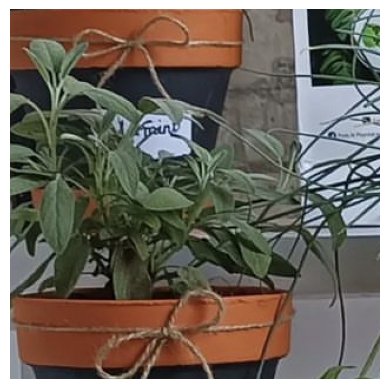

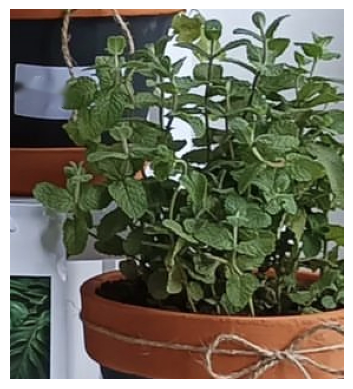

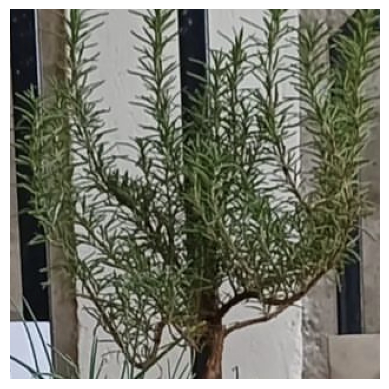

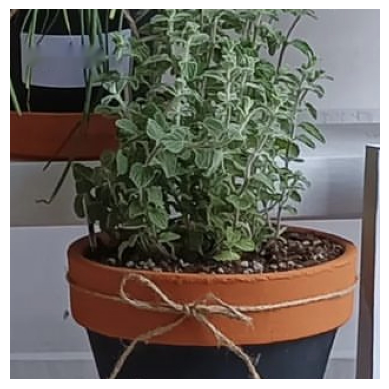

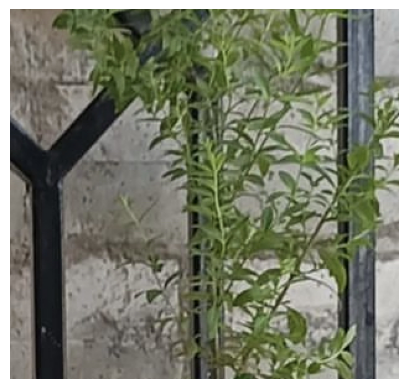

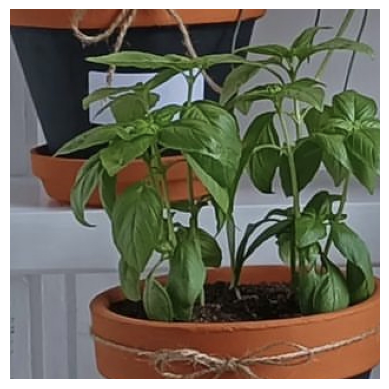

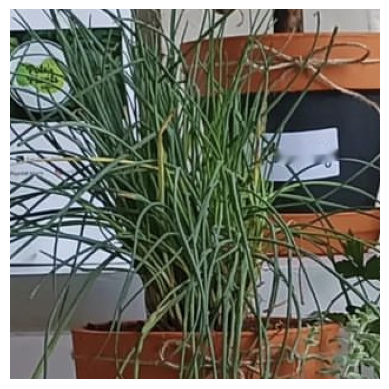

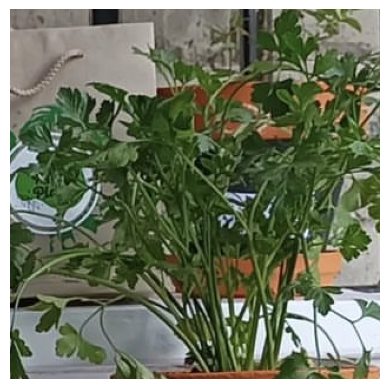

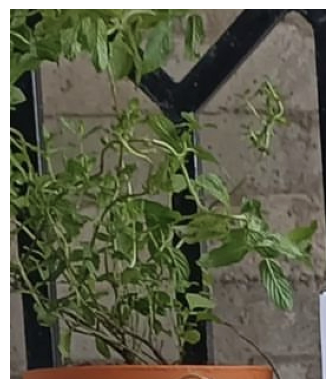

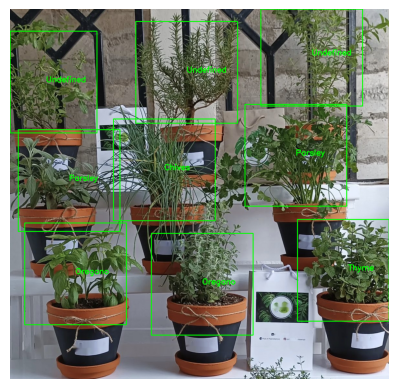

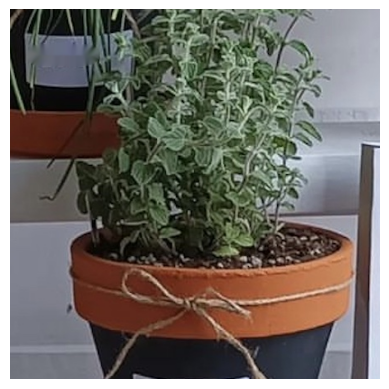

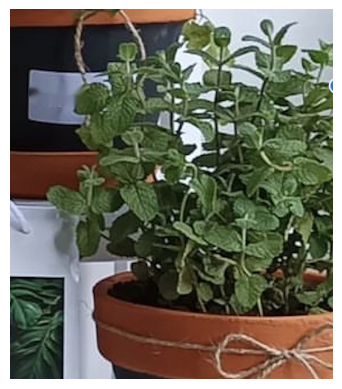

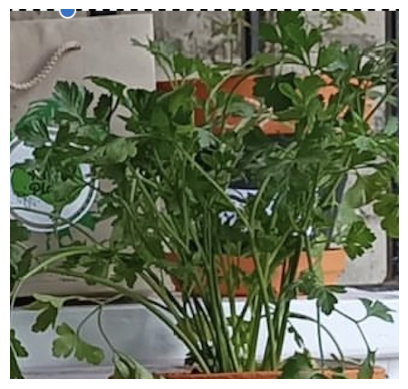

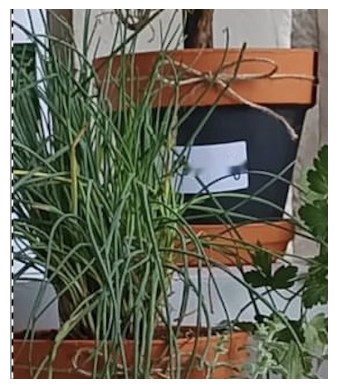

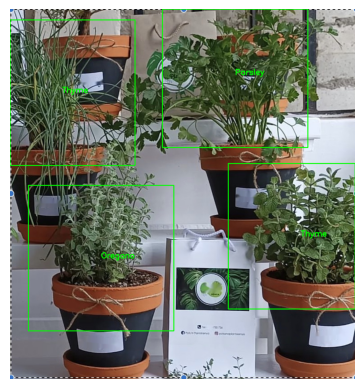

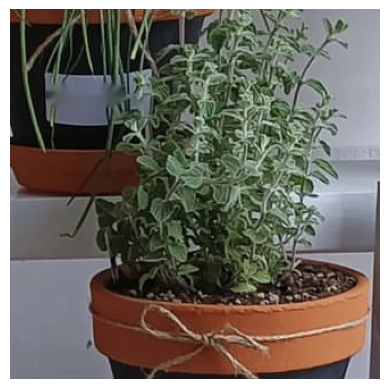

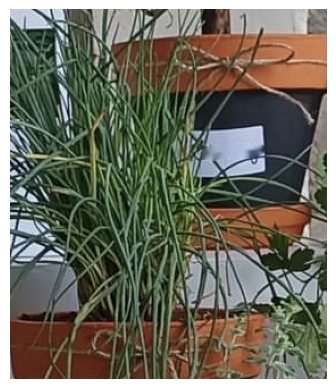

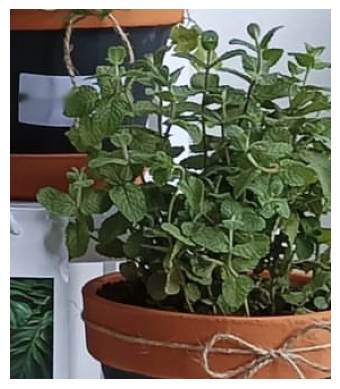

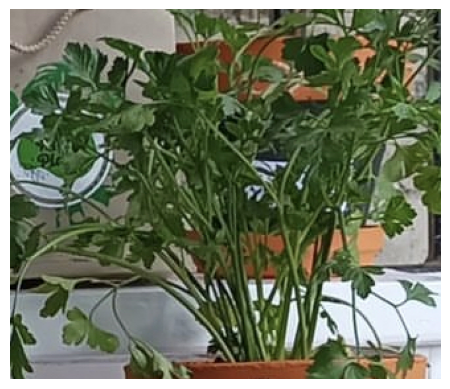

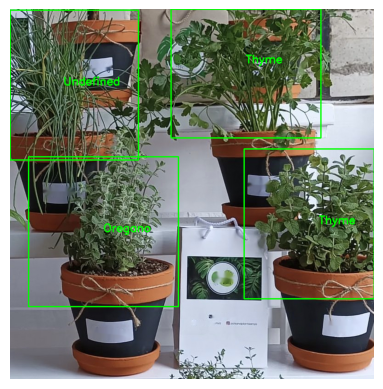

In [ ]:
#extract subImages
directory = "gdrive/MyDrive/CV_Project/images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        stats = get_properties(img_path,'gaussian')
        out_path = os.path.join(directory,photo_file,"subsetImages")
        n = num_clusters[int(photo_file[3:])]
        centers = get_center(stats,n_clusters = n)
        box=get_subImages_box(img_path,centers,out_path)
        out_path = os.path.join(directory,photo_file,"result.png")
        fig, ax = plt.subplots()
        # img = mpimg.imread(img_path)
        ax.imshow(box)

        ax.set_axis_off()
        dpi = box.shape[0] / fig.get_size_inches()[0] 
        plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)

        